In [1]:
from sklearn.cluster import KMeans # KMedoids clust = KMedoids(n_clusters=20, random_state=0, metric='euclidean').fit(d1)
import numpy as np
import joblib
import os, yaml, sys
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_relevant_output_layers
from sparsity_in_silico.sparsity_CNN import response_prob, rust_sparseness
from sklearn.cluster import KMeans
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alignment.utils import get_usual_transform
from alignment.CKA import cka, cka_minibatch, cka_batch_collection
import math
from scipy.stats import spearmanr

In [2]:
model_name = "alexnet"
target_layer = "classifier.2"
pooling = "ran"
path2data = f"{paths['results_path']}/imagenet_val_{model_name}_{target_layer}_{pooling}_features.pkl"

In [3]:
data = joblib.load(path2data)

In [4]:
variances = np.var(data, axis=0)
data_nonconst = data[:, variances != 0]
b = np.corrcoef(data_nonconst.T)


In [5]:
p_gt = response_prob(data_nonconst.T)

In [6]:
a = data_nonconst.T @ data_nonconst / data_nonconst.shape[1]

In [7]:
b = np.corrcoef(data_nonconst.T)

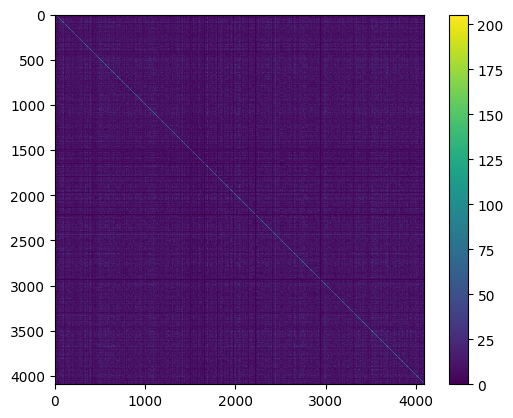

In [8]:
plt.imshow(a, cmap='viridis', interpolation='nearest')
plt.colorbar()

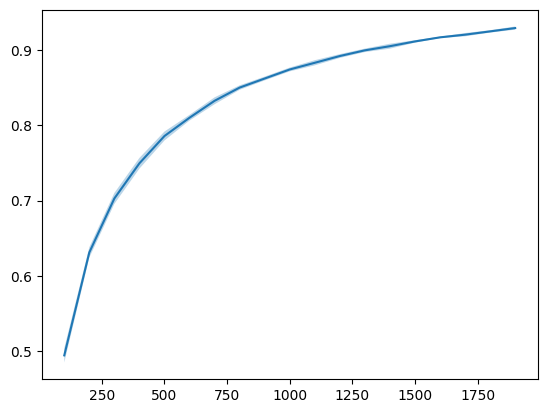

In [9]:
# do random subsampling (repeated many times) and see when this happens to converge
start, stop, step = 100, 2000, 100
num_reps = 10
correlations = []
sem = []
RDM = np.cov(data_nonconst.T)
RDM_idx = np.tril_indices(RDM.shape[0], k=-1)
flat_RDM = RDM[RDM_idx]
for N in range(start, stop, step): # TODO do it with cov instead of np.corrcoefs bc we're getting nans
    curr_corr = []
    for rep in range(num_reps):
        random_samples = np.random.choice(data_nonconst.shape[0], N, replace=False)
        new_data = data_nonconst[random_samples,:]
        new_RDM = np.cov(new_data.T)
        new_RDM_idx = np.tril_indices(new_RDM.shape[0], k=-1)
        flat_new_RDM = new_RDM[new_RDM_idx]
        r = np.corrcoef(flat_RDM, flat_new_RDM)[0,1]
        curr_corr.append(r)
    # for rep in range(num_reps):
    avg_r = np.mean(np.stack(curr_corr))
    sem_r = np.std(np.stack(curr_corr))
    correlations.append(avg_r)
    sem.append(sem_r)
# end for N in range(start, stop, step):
plt.plot(range(start, stop, step), correlations)
plt.fill_between(range(start, stop, step), np.stack(correlations) - np.stack(sem), np.stack(correlations) + np.stack(sem), alpha=0.3, label='Error range')

In [8]:
def sum_of_square_deviations(cov, cov_estim):
    diff_mat = cov - cov_estim
    sq_diff_mat = diff_mat**2
    d = np.shape(cov)[0]
    diff_frob_norm = np.sqrt(np.sum(sq_diff_mat))
    return diff_frob_norm/d

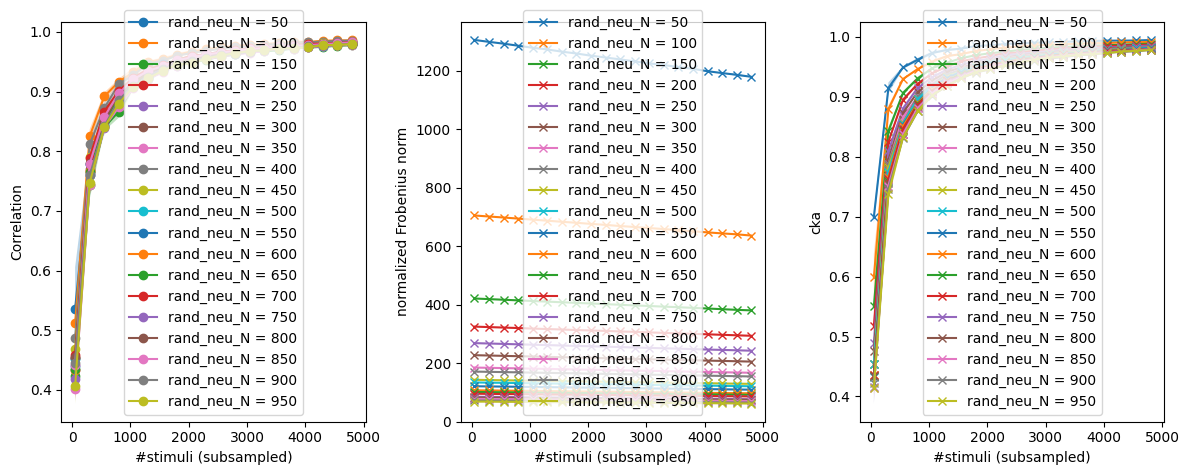

In [9]:
# do random subsampling (repeated many times) and see when this happens to converge

start, stop, step = 50, 5000, 250
startn, stopn, stepn = 50, 1000, 50
num_reps = 5
fig, axs = plt.subplots(1, 3, figsize=(12, 5)) 
for rand_neu_N in range(startn, stopn, stepn):
    correlations = []
    sem = []
    frob_norms = []
    sem_fn = []
    """
    klds = []
    sem_klds = []
    """
    ckas = []
    sem_ckas = []
    
    random_neu = np.random.choice(data_nonconst.shape[1], rand_neu_N, replace=False)    
    curr_data = data_nonconst[:,random_neu]
    #print("size curr_data", curr_data.sape)
    curr_RDM = curr_data.T @ curr_data # curr_data @ curr_data.T for the gram
    curr_RDM_idx = np.tril_indices(curr_RDM.shape[0], k=-1)
    curr_flat_RDM = curr_RDM[curr_RDM_idx]
    #curr_resp_prob = rust_sparseness(curr_data.T)
    #curr_cka = cka_exact(curr_data)
    for N in range(start, stop, step): 
        curr_corr = []
        curr_fn = []
        #curr_kld = []
        curr_cka = []
        for rep in range(num_reps):
            random_samples = np.random.choice(data_nonconst.shape[0], N, replace=False)
            new_data = curr_data[random_samples,:]
            #print("size new_data", new_data.shape)
            new_RDM = new_data.T @ new_data #new_data @ new_data.T
            new_RDM_idx = np.tril_indices(new_RDM.shape[0], k=-1)
            flat_new_RDM = new_RDM[new_RDM_idx]
            r = np.corrcoef(curr_flat_RDM, flat_new_RDM)[0,1]
            curr_corr.append(r)
            
            fn = sum_of_square_deviations(curr_flat_RDM, flat_new_RDM)
            curr_fn.append(fn)
            """
            new_resp_prob = rust_sparseness(new_data.T)
            kld, pval = spearmanr(curr_flat_RDM, flat_new_RDM)
            curr_kld.append(kld)
            curr_kld.append(kld)
            """
            cka_ = cka(curr_data.T, new_data.T)
            curr_cka.append(cka_)
        # for rep in range(num_reps):
        avg_r = np.mean(np.stack(curr_corr))
        sem_r = np.std(np.stack(curr_corr))
        correlations.append(avg_r)
        sem.append(sem_r)
        
        avg_fn = np.mean(np.stack(curr_fn))
        curr_sem_fn = np.std(np.stack(curr_fn))
        frob_norms.append(avg_fn)
        sem_fn.append(curr_sem_fn)
        
        """
        #avg_kld = np.mean(np.stack(curr_kld))
        #curr_sem_kld = np.std(np.stack(curr_kld))
        #klds.append(avg_kld)
        #sem_klds.append(curr_sem_kld)
        """
        avg_cka = np.mean(np.stack(curr_cka))
        curr_sem_cka = np.std(np.stack(curr_cka))
        ckas.append(avg_cka)
        sem_ckas.append(curr_sem_cka)
    # end for N in range(start, stop, step):
    axs[0].plot(range(start, stop, step), correlations, marker='o', label=f"rand_neu_N = {rand_neu_N}")
    axs[0].fill_between(range(start, stop, step),
                        np.stack(correlations) - np.stack(sem),
                        np.stack(correlations) + np.stack(sem),
                        alpha=0.3, label="_nolegend_")
    axs[0].set_xlabel("#stimuli (subsampled)")
    axs[0].set_ylabel("Correlation")
    axs[0].legend()
    
    axs[1].plot(range(start, stop, step), frob_norms, marker='x', label=f"rand_neu_N = {rand_neu_N}")
    axs[1].fill_between(range(start, stop, step),
                    np.stack(frob_norms) - np.stack(sem_fn),
                    np.stack(frob_norms) + np.stack(sem_fn),
                    alpha=0.3, label="_nolegend_")
    axs[1].set_xlabel("#stimuli (subsampled)")
    axs[1].set_ylabel("normalized Frobenius norm")
    axs[1].legend()
    """
    axs[2].plot(range(start, stop, step), klds, marker='x', label=f"rand_neu_N = {rand_neu_N}")
    axs[2].fill_between(range(start, stop, step),
                    np.stack(klds) - np.stack(sem_klds),
                    np.stack(klds) + np.stack(sem_klds),
                    alpha=0.3, label="_nolegend_")
    axs[2].set_xlabel("#stimuli (subsampled)")
    axs[2].set_ylabel("kld")
    axs[2].legend()
    """
    axs[2].plot(range(start, stop, step), ckas, marker='x', label=f"rand_neu_N = {rand_neu_N}")
    axs[2].fill_between(range(start, stop, step),
                    np.stack(ckas) - np.stack(sem_ckas),
                    np.stack(ckas) + np.stack(sem_ckas),
                    alpha=0.3, label="_nolegend_")
    axs[2].set_xlabel("#stimuli (subsampled)")
    axs[2].set_ylabel("cka")
    axs[2].legend()
# for rand_neu in range(startn, stopn, stepn):
plt.tight_layout()
plt.show()

In [40]:
def cont_kld(samples_p, samples_q):
    kde_p = gaussian_kde(samples_p)
    kde_q = gaussian_kde(samples_q)
    
    # Define shared domain
    xmin = min(samples_p.min(), samples_q.min())
    xmax = max(samples_p.max(), samples_q.max())
    margin = (xmax - xmin) * 0.1
    
    # Get bandwidth estimate from KDE
    # Use the average bandwidth for sampling density
    std_p = samples_p.std()
    std_q = samples_q.std()
    bw_p = kde_p.factor * std_p
    bw_q = kde_q.factor * std_q
    bandwidth = (bw_p + bw_q) / 2
    points_per_band = 20
    N = int((xmax - xmin + 2 * margin) / bandwidth * points_per_band)
    N = max(N, 200)   # Make sure it's not too small# Create grid
    x = np.linspace(xmin - margin, xmax + margin, N)
    p = kde_p(x)
    q = kde_q(x)
    
    # Avoid division by zero
    mask = (p > 0) & (q > 0)
    
    # Approximate KL divergence
    kl = simpson(p[mask] * np.log(p[mask] / q[mask]), x[mask])
    return kl

In [41]:
def cont_kld(samples_p, samples_q):
    kde_p = gaussian_kde(samples_p)
    kde_q = gaussian_kde(samples_q)
    
    # Define shared domain
    xmin = min(samples_p.min(), samples_q.min())
    xmax = max(samples_p.max(), samples_q.max())
    margin = (xmax - xmin) * 0.1
    
    # Get bandwidth estimate from KDE
    # Use the average bandwidth for sampling density
    std_p = samples_p.std()
    std_q = samples_q.std()
    bw_p = kde_p.factor * std_p
    bw_q = kde_q.factor * std_q
    bandwidth = (bw_p + bw_q) / 2
    points_per_band = 20
    N = int((xmax - xmin + 2 * margin) / bandwidth * points_per_band)
    N = max(N, 200)   # Make sure it's not too small# Create grid
    x = np.linspace(xmin - margin, xmax + margin, N)
    p = kde_p(x)
    q = kde_q(x)
    
    # Avoid division by zero
    mask = (p > 0) & (q > 0)
    
    # Approximate KL divergence
    kl = simpson(p[mask] * np.log(p[mask] / q[mask]), x[mask])
    print("KL(P || Q) =", kl)
    return kl

In [45]:
samples_p = np.random.normal(0, 1, size=1000)
samples_q = np.random.normal(0, 2, size=1000)
cont_kld(samples_p, samples_q)

KL(P || Q) = 0.3170876375414221


np.float64(0.3170876375414221)